<center><h1 style="font-size:40px;">Project 1<br> Recurrent Neural Networks
</h1></center>

---

This project will develop an **Recurrent neural network (RNN)**. The task is to predict the next image in a series.

The task provide a dataset which creates a series of images where the last image in the series is the target. 

All **tasks** include **TODO's** thare are expected to be done before the deadline. The highlighted **Question's** should be answered in the report. Keep the answers separated so it is easy to read for the grading. Some sections include asserts or an expected result to give a and expected results are given. Some sections does not contain any **TODO's** but is good to understand them. 

For the **report** we have prepared an *Report.ipynb* notebook. The report should act as a summary of your findings and motivate your choice of approach. A better motivation show your understanding of the lab. Dont forget to include all **parts** in the report!

This lab logs metrics to **Tensorboard**, for instructions to install check the introduction pdf.

Good luck!

---

# Task

**TODO:** Implement **RNN** to predict the next image in the series. 

**TODO:** Select a good metric to evaluate the models performance and argue why the metric give a good overview of the performance.

**Question:** Explain in the report what you did and why. Present a pipeline of the code. 

--- 

**Note:** The current image resolution is set to 32x32 (i.e. IMAGE_WIDTH and IMAGE_HEIGHT) in config.py. 
This way initial experiements can run faster. Once you implement the inital version of the network, please set the resolution values back to 128x128. Experimental results should be provided for this high resolution images.  

**Hint:** As a generator model, you can use the segmentation model implemented in lab03. Do not forget to adapt the input and output shapes of the generator model in this case.




# Import packages

In [1]:
%load_ext autoreload
%autoreload 2
# Hacky solution to ac>cess the global utils package
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('../..')))

In [2]:
from config import LabConfig
import torchmetrics
import transforms as T
import torchvision
import torch
from torch.utils.data import DataLoader
from DL_labs.utils.dataset import FutureFramePredictorDataset
from DL_labs.utils.plot import RNN

## Load config
Note that this lab does not support for fineGrained dataset.

In [3]:
cfg = LabConfig()
cfg.todict()

{'training_img_dir': '../../data/FlyingObjectDataset_10K/training/image',
 'validation_img_dir': '../../data/FlyingObjectDataset_10K/validation/image',
 'testing_img_dir': '../../data/FlyingObjectDataset_10K/testing/image',
 'SEQUENCE_LENGTH': 7,
 'SEED': 420,
 'GPU': -1,
 'IMAGE_WIDTH': 128,
 'IMAGE_HEIGHT': 128,
 'IMAGE_CHANNEL': 3,
 'NUM_WORKERS': 4,
 'BATCH_SIZE': 32,
 'TENSORBORD_DIR': 'logs/'}

# Dataset
First load the dataloaders for three datasets; train, validation and test. Feel free to test different augmentations, more can be found at *https://pytorch.org/vision/stable/transforms.html*

The dataset consist of a series of images where the last image in the series are the target image. All other images use the target image for the prediction. 

Note that ToTensor and Rezise are required to reshape and transform the images correct. We do not want to apply augmentation to the test_transform that are applied on the validation and test dataloader. For semantic segmentation we do not only have an input image $x$ but also an target label $y$. If we apply example: *RandomHorizontalFlip* the expected target image will be observed but will not be same rotation.

**Hint:** To ensure that the CNN take the images as a sequence the images are concatenated along the channel dimension. The input shape will look like: $(batch\_size*sequence\_length, C, H, W)$. Also, test: $x.view(batch\_size, sequence\_length, -1)$ to process the images in a sequence after CNN.

## Augmentation
To ensure that each image have the same shape we pad the dataset. It is possible to resize the images but then the bounding boxes also have to be transformed to correct shape which is not covered in this project! 

In [4]:
train_transform = T.Compose([
    T.ToTensor(),
    T.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),interpolation=torchvision.transforms.InterpolationMode.NEAREST), 
])
test_transform = T.Compose([
    T.ToTensor(),
    T.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),interpolation=torchvision.transforms.InterpolationMode.NEAREST), #, 
])

## Dataloader

In [5]:
train_dataloader = DataLoader(
    FutureFramePredictorDataset(
        cfg.training_img_dir, 
        cfg.SEQUENCE_LENGTH,
        img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), 
        transforms=train_transform),
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS

)

valid_dataloader = DataLoader(
    FutureFramePredictorDataset(
        cfg.validation_img_dir, 
        cfg.SEQUENCE_LENGTH,
        img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), 
        transforms=test_transform),
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS
)
test_dataloader = DataLoader(
    FutureFramePredictorDataset(
        cfg.testing_img_dir, 
        cfg.SEQUENCE_LENGTH,
        img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), 
        transforms=test_transform),
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS
)

print("Data batch generators are created!")

Data batch generators are created!


## Visualise data
To get an idea of the dataset we will first plot the data. This is very important, especially if we perform data augmentation. If the implementation is wrong an qualitative estimation will with a great probability tell if something is wrong.

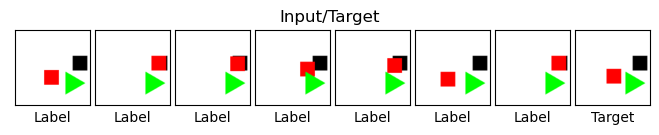

In [6]:
t_x, t_y = next(iter(train_dataloader))
RNN.data(t_x, t_y, cfg.SEQUENCE_LENGTH, nrows=1, title_size=2)

# Implementation

---